In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm.notebook import trange

In [2]:
train_data = pd.read_csv('data/train.csv')
train_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = train_data.drop('label', axis=1).values.reshape(-1,28,28)
y = train_data.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
len(X_train), len(X_test)

(31500, 10500)

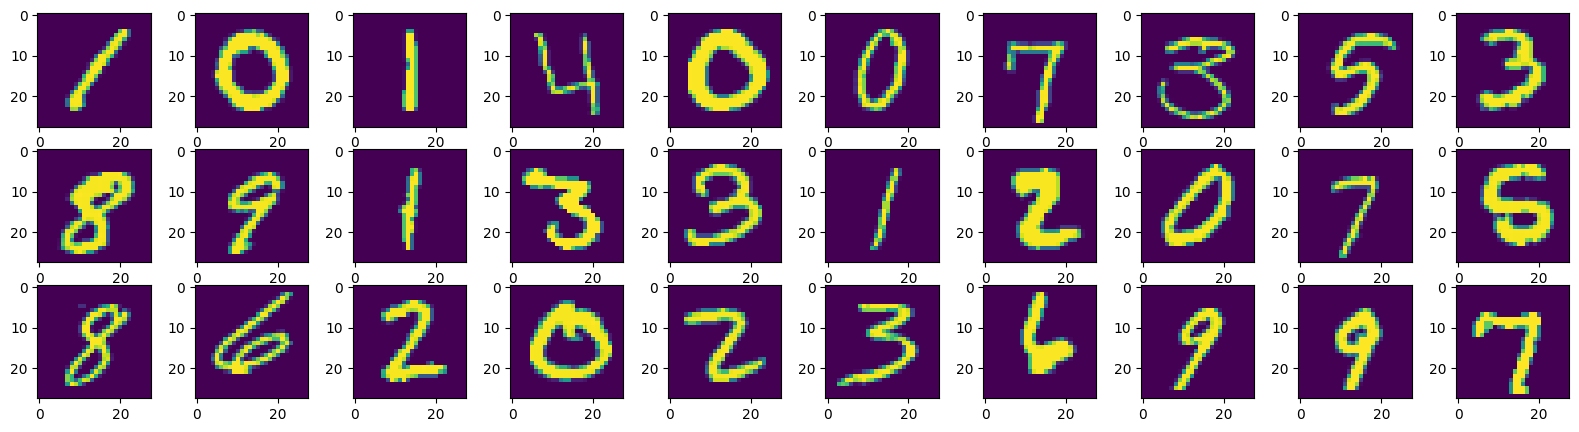

In [5]:
to_plot = X[:30]
fig = plt.figure(figsize=(20,5))
for i,val in enumerate(to_plot):
    ax = fig.add_subplot(3,10,i+1)
    ax.imshow(val)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
class MLP(nn.Module):
    def __init__(self, inp, h1, out):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(inp, h1)
        self.l2 = nn.ReLU()
        self.l3 = nn.Linear(h1, out)
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        return out

model = MLP(28*28, 100, 10).to(device)

In [15]:
loss_category = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
bs = 50000
epochs = 500

In [9]:
class MNIST(Dataset):
    def __init__(self, x_, y_):
        self.X = x_
        self.y = y_
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = MNIST(X_train, y_train)
test_dataset = MNIST(X_test, y_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
len(train_dataset), len(test_dataset)

(31500, 10500)

In [23]:
for epoch in trange(epochs):
    for x_,y_ in train_dataloader:
        x_ = x_.float().to(device).view(-1, 28*28)
        y_ = y_.int().to(device)

        # forward pass
        y_pred = model(x_)
        y_ = F.one_hot(y_.clone().detach().long(), 10).float()

        # calc loss
        loss = loss_category(y_pred, y_)

        # backprop
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
    if (epoch+1)%10 == 0: print(f'Epoch {epoch+1}: {loss.item():2f}')


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10: 1.060300
Epoch 20: 1.058538
Epoch 30: 1.057486
Epoch 40: 1.061367
Epoch 50: 1.063895
Epoch 60: 1.055837


In [17]:
with torch.no_grad():
    score = 0
    ct = 0
    for x_,y_ in train_dataloader:
        x_ = x_.float().to(device).view(-1, 28*28)
        y_ = y_.int().to(device)

        y_pred = model(x_)
        for i,j in zip(y_, torch.argmax(y_pred, dim=1)):
            score += i.item() == j.item()
            ct += 1
    print(f'Train Accuracy {score*100/ ct} %')


Train Accuracy 55.74603174603175 %


In [18]:
with torch.no_grad():
    score = 0
    ct = 0
    for x_,y_ in test_dataloader:
        x_ = x_.float().to(device).view(-1, 28*28)
        y_ = y_.int().to(device)

        y_pred = model(x_)
        for i,j in zip(y_, torch.argmax(y_pred, dim=1)):
            score += i.item() == j.item()
            ct += 1
    print(f'Test Accuracy {score*100/ ct} %')

Test Accuracy 54.819047619047616 %


# Kaggle Inference

In [19]:
data= pd.read_csv('data/test.csv')

In [20]:
y = torch.ones(data.shape)
dataset = MNIST(data.values, y)
kaggle_dataloader = DataLoader(dataset=dataset, batch_size=bs, shuffle=False)

In [21]:
with torch.no_grad():
    score = 0
    ct = 0
    ans = []
    for x_,some_other_y_value in kaggle_dataloader:
        x_ = x_.float().to(device).view(-1, 28*28)

        y_pred = model(x_)
        ans.extend(list(torch.argmax(y_pred, dim=1)))
        

In [22]:
out = {'ImageId':[i for i in range(1, 28001)], 'Label': ans}
df = pd.DataFrame(out)
df.to_csv('data/output.csv', index=False)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Best Accuracy: 92.7 %